Split: 80% train, 10% val, 10% test

In [1]:
from pathlib import Path
import shutil, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

CONFIG

In [2]:
# CLEAN_DIR هو مجلد النسخة النظيفة اللي خلّصناها بالتنظيف
CLEAN_DIR = Path("./ArASL_Cleaned")      # عدّلي المسار إذا لزم
SPLIT_DIR = Path("./ArASL_Split")        # هنا راح نحط train/val/test
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

#  نسب التقسيم — 80/10/10
TRAIN_RATIO = 0.8
VAL_RATIO   = 0.1
TEST_RATIO  = 0.1
assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-6, "Ratios must sum to 1."

# ثبّتي العشوائية
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp"}

def is_image(p: Path) -> bool:
    """Return True if file extension is an image."""
    return p.suffix.lower() in IMG_EXTS

SCAN CLEANED

In [3]:
# نجمع كل الملفات المصنّفة (class folders) من CLEAN_DIR
assert CLEAN_DIR.exists(), f"Cleaned dataset not found: {CLEAN_DIR}"

classes = sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "No class folders found in CLEAN_DIR."

items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            items.append({"class": c.name, "path": p})

df = pd.DataFrame(items)
print(f"[INFO] classes: {len(classes)} | images: {len(df)}")

[INFO] classes: 32 | images: 48422


STRATIFIED SPLIT (per class)

In [4]:
#  نقسم داخل كل كلاس إلى 3 قوائم حسب النسب (مع خلط عشوائي ثابت)
def stratified_split_paths(paths, train_ratio, val_ratio, test_ratio, seed=RANDOM_SEED):
    n = len(paths)
    idx = list(range(n))
    random.Random(seed).shuffle(idx)  # تثبيت العشوائية لكل استدعاء
    n_train = int(round(n * train_ratio))
    n_val   = int(round(n * val_ratio))
    n_test  = n - n_train - n_val     # الباقي للتست لتجنب أثر التقريب

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]

    train = [paths[i] for i in train_idx]
    val   = [paths[i] for i in val_idx]
    test  = [paths[i] for i in test_idx]
    return train, val, test

REATE DEST FOLDERS


In [5]:
#  نجهّز مجلدات الوجهات لكل split ولكل class
for split in ["train", "val", "test"]:
    for c in classes:
        (SPLIT_DIR / split / c.name).mkdir(parents=True, exist_ok=True)

SPLIT & COPY FILES


In [6]:
#  نقسّم وننسخ الملفات إلى المجلدات المناسبة
split_rows = []

for c in classes:
    cls = c.name
    paths = [p for p in c.iterdir() if is_image(p)]
    train_paths, val_paths, test_paths = stratified_split_paths(
        paths, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, seed=RANDOM_SEED
    )

    # نسخ الملفات
    for split_name, plist in [("train", train_paths), ("val", val_paths), ("test", test_paths)]:
        for src in plist:
            dst = SPLIT_DIR / split_name / cls / src.name
            shutil.copy2(src, dst)
            split_rows.append({"split": split_name, "class": cls, "path": dst})

df_split = pd.DataFrame(split_rows)
print("[INFO] split done.")
print("Target folder:", SPLIT_DIR.resolve())

[INFO] split done.
Target folder: /Users/amirah/Desktop/Sila - Data prep/ArASL_Split



COUNTS (PER SPLIT & CLASS)

In [7]:
#  نحسب عدد الصور لكل كلاس داخل كل split
def count_by_split(df_split: pd.DataFrame) -> pd.DataFrame:
    return (df_split.groupby(["split", "class"])["path"].count()
            .reset_index()
            .rename(columns={"path": "count"})
            .sort_values(["split", "class"])
            .reset_index(drop=True))

df_counts = count_by_split(df_split)
display(df_counts)

# NOTE (Arabic): ملخص سريع بعد التقسيم — كم صورة في كل split إجمالًا
summary = (df_split.groupby(["split"])["path"].count()
           .reset_index()
           .rename(columns={"path": "total_images"}))
display(summary)

# نحفظ الجداول كـ CSV مرجع
df_counts.to_csv(SPLIT_DIR / "class_counts_per_split.csv", index=False)
summary.to_csv(SPLIT_DIR / "split_totals.csv", index=False)

,split,class,count
0,test,ain,193
1,test,al,134
2,test,aleff,148
3,test,bb,161
4,test,dal,145
...,...,...,...
91,val,toot,160
92,val,waw,120
93,val,ya,152
94,val,yaa,129


,split,total_images
0,test,4842
1,train,38738
2,val,4842


VISUALIZE: GROUPED BAR CHART


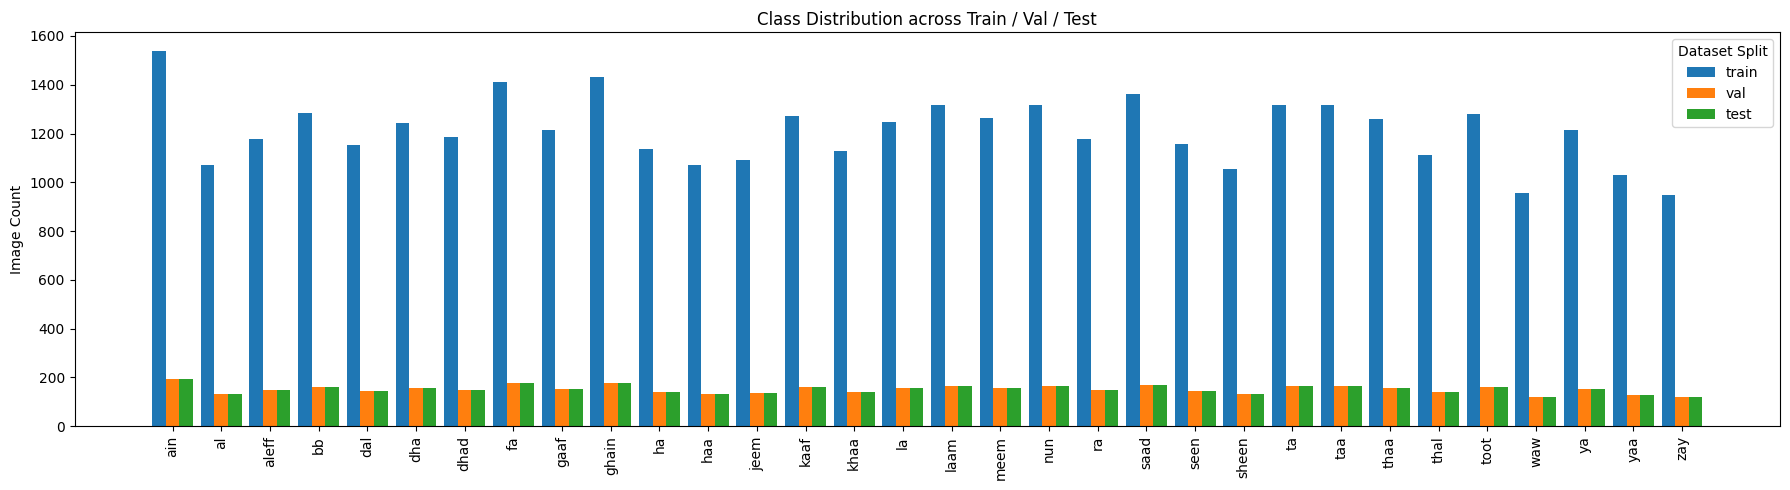

In [8]:
# مقارنة توزيع الكلاسات بين train/val/test (بدون seaborn)
dfp = df_counts.pivot(index="class", columns="split", values="count").fillna(0).sort_index()
splits = ["train", "val", "test"]
classes_order = dfp.index.tolist()

x = np.arange(len(classes_order))
width = 0.28

plt.figure(figsize=(18, 5))
for i, s in enumerate(splits):
    plt.bar(x + (i - 1) * width, dfp[s].values, width, label=s)

plt.xticks(x, classes_order, rotation=90)
plt.ylabel("Image Count")
plt.title("Class Distribution across Train / Val / Test")
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()

	تأكيد أن التقسيم فعلاً 80/10/10 لكل كلاس

In [9]:
chk = df_counts.pivot(index="class", columns="split", values="count").fillna(0)
chk["total"] = chk.sum(axis=1)
chk["train%"] = (chk["train"]/chk["total"]*100).round(1)
chk["val%"]   = (chk["val"]/chk["total"]*100).round(1)
chk["test%"]  = (chk["test"]/chk["total"]*100).round(1)
display(chk[["train%","val%","test%"]])

split,train%,val%,test%
class,,,
ain,80.0,10.0,10.0
al,80.0,10.0,10.0
aleff,80.0,10.0,10.0
bb,80.0,10.0,10.0
dal,80.0,10.0,10.0
dha,80.0,10.0,10.0
dhad,80.0,10.0,10.0
fa,80.0,10.0,10.0
gaaf,80.0,10.0,10.0
